In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import pickle
import requests
from collections import Counter

from sklearn.metrics import mean_squared_error, mean_absolute_error


from fbprophet import Prophet

from fbprophet.diagnostics import cross_validation


# Load In Data

In [2]:
with open('amzn.pickle','rb') as read_file:
    amzn_df = pickle.load(read_file)

In [3]:
with open('msft.pickle','rb') as read_file:
    msft_df = pickle.load(read_file)

In [4]:
with open('fb.pickle','rb') as read_file:
    fb_df = pickle.load(read_file)

In [5]:
with open('googl.pickle','rb') as read_file:
    googl_df = pickle.load(read_file)

In [6]:
with open('aapl.pickle','rb') as read_file:
    aapl_df = pickle.load(read_file)

# Compute Market Cap

https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

Comparing the two companies on stock prices alone does not show which is more valuable because the total value of a company (market capitalization) also depends on the number of shares (Market cap= share price * number of shares)

In [7]:
# Yearly average number of shares outstanding for Big 5
amzn_shares = {2019: 503e6, 2018: 500e6, 2017: 493e6, 2016: 484e6, 2015: 477e6}
msft_shares = {2019: 7.753e9 ,2018: 7.768e9, 2017: 7.71e9, 2016: 7.83e9, 2015: 8.051e9}
fb_shares = {2019: 2.875e9,2018: 2.921e9, 2017: 2.956e9, 2016: 2.925e9, 2015: 2.853e9}
googl_shares = {2019: 746e6 ,2018: 750e6, 2017: 751e6, 2016: 748e6, 2015: 745e6}
aapl_shares = {2019: 4.601e9,2018: 4.773e9, 2017: 5.158e9, 2016: 5.328e9, 2015: 5.594e9}

In [8]:
amzn_df['year'] = pd.to_datetime(amzn_df['date']).dt.year
msft_df['year'] = pd.to_datetime(amzn_df['date']).dt.year
fb_df['year'] = pd.to_datetime(amzn_df['date']).dt.year
googl_df['year'] = pd.to_datetime(amzn_df['date']).dt.year
aapl_df['year'] = pd.to_datetime(amzn_df['date']).dt.year

In [9]:
for i, year in enumerate(amzn_df['year']):
    amzn_df.loc[i, 'AMZN_cap'] = amzn_shares.get(year) * amzn_df.loc[i, 'adjClose']   
    msft_df.loc[i, 'MSFT_cap'] = msft_shares.get(year) * msft_df.loc[i, 'adjClose']
    fb_df.loc[i, 'FB_cap'] = fb_shares.get(year) * fb_df.loc[i, 'adjClose']   
    googl_df.loc[i, 'GOOGL_cap'] = googl_shares.get(year) * googl_df.loc[i, 'adjClose']
    aapl_df.loc[i, 'AAPL_cap'] = aapl_shares.get(year) * aapl_df.loc[i, 'adjClose']

In [10]:
amzn_df.head(5)

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume,year,AMZN_cap
0,AMZN,2015-01-02,308.52,314.75,306.9601,312.58,2788101,308.52,0.0,314.75,306.9601,312.58,1.0,2788101,2015,1.471640e+11
1,AMZN,2015-01-05,302.19,308.38,300.8500,307.01,2774231,302.19,0.0,308.38,300.8500,307.01,1.0,2774231,2015,1.441446e+11
2,AMZN,2015-01-06,295.29,303.00,292.3800,302.24,3519034,295.29,0.0,303.00,292.3800,302.24,1.0,3519034,2015,1.408533e+11
3,AMZN,2015-01-07,298.42,301.28,295.3300,297.50,2640349,298.42,0.0,301.28,295.3300,297.50,1.0,2640349,2015,1.423463e+11
4,AMZN,2015-01-08,300.46,303.14,296.1100,300.32,3088398,300.46,0.0,303.14,296.1100,300.32,1.0,3088398,2015,1.433194e+11


In [11]:
msft_df.head(5)

,symbol,date,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,divCash,high,low,open,splitFactor,volume,year,MSFT_cap
0,MSFT,2015-01-02,42.124356,42.718926,41.926167,42.034270,27913852,46.760,0.0,47.4200,46.54,46.66,1.0,27913852,2015,3.391432e+11
1,MSFT,2015-01-05,41.732481,42.097331,41.664916,41.773020,39673865,46.325,0.0,46.7300,46.25,46.37,1.0,39673865,2015,3.359882e+11
2,MSFT,2015-01-06,41.124399,42.114447,41.025304,41.782029,36447854,45.650,0.0,46.7490,45.54,46.38,1.0,36447854,2015,3.310925e+11
3,MSFT,2015-01-07,41.646899,41.854098,40.980260,41.421683,29114061,46.230,0.0,46.4600,45.49,45.98,1.0,29114061,2015,3.352992e+11
4,MSFT,2015-01-08,42.872073,43.016121,42.088322,42.115348,29645202,47.590,0.0,47.7499,46.72,46.75,1.0,29645202,2015,3.451631e+11


In [12]:
tech_stocks = amzn_df[['date', 'AMZN_cap']]\
            .merge(msft_df[['date', 'MSFT_cap']], on='date')\
            .merge(fb_df[['date', 'FB_cap']], on='date')\
            .merge(googl_df[['date', 'GOOGL_cap']], on='date')\
            .merge(aapl_df[['date', 'AAPL_cap']], on='date')

tech_stocks['AMZN_cap'] = tech_stocks['AMZN_cap'] / 1e9
tech_stocks['MSFT_cap'] = tech_stocks['MSFT_cap'] / 1e9
tech_stocks['FB_cap'] = tech_stocks['FB_cap'] / 1e9
tech_stocks['GOOGL_cap'] = tech_stocks['GOOGL_cap'] / 1e9
tech_stocks['AAPL_cap'] = tech_stocks['AAPL_cap'] / 1e9

tech_stocks.head(5)

,date,AMZN_cap,MSFT_cap,FB_cap,GOOGL_cap,AAPL_cap
0,2015-01-02,147.16404,339.143194,223.817850,394.51475,563.570212
1,2015-01-05,144.14463,335.988205,220.223070,386.99770,547.693543
2,2015-01-06,140.85333,331.092532,217.255950,377.44680,547.745090
3,2015-01-07,142.34634,335.299184,217.255950,376.33675,555.425687
4,2015-01-08,143.31942,345.163058,223.033275,377.64795,576.766405


<Figure size 1008x720 with 0 Axes>

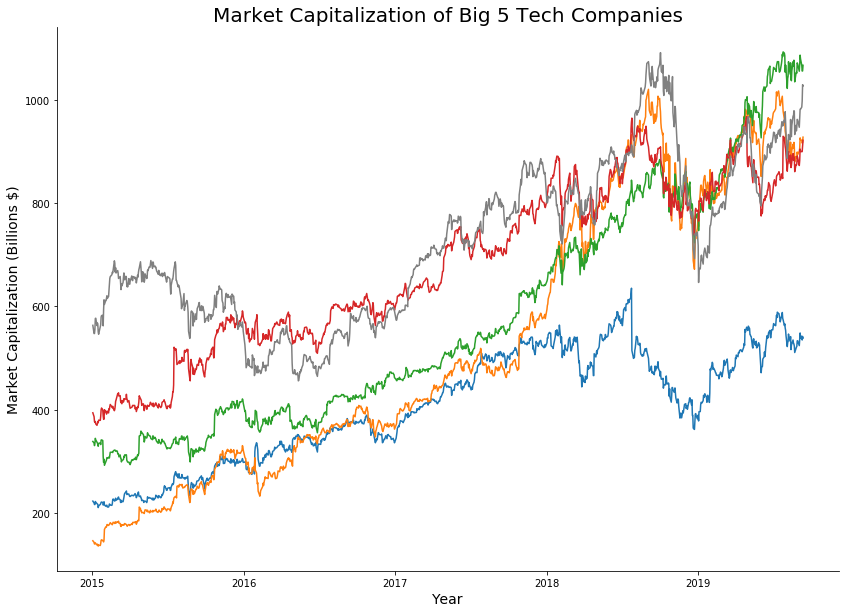

In [13]:
plt.figure(figsize=(14, 10))
fig, ax = plt.subplots(figsize=(14, 10))

fig = figsize=(14, 10)
ax.plot(tech_stocks['date'], tech_stocks['FB_cap'], label = 'FB')
ax.plot(tech_stocks['date'], tech_stocks['AMZN_cap'], label = 'AMZN')
ax.plot(tech_stocks['date'], tech_stocks['MSFT_cap'], label = 'MSFT')
ax.plot(tech_stocks['date'], tech_stocks['GOOGL_cap'], label = 'GOOGL')
ax.plot(tech_stocks['date'], tech_stocks['AAPL_cap'], label = 'AAPL', color="gray")
plt.xlabel('Year', fontsize=14)
plt.ylabel('Market Capitalization (Billions $)', fontsize=14)
plt.title('Market Capitalization of Big 5 Tech Companies', fontsize=20)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [14]:
with open('market_cap.pickle', 'wb') as to_write:
    pickle.dump(tech_stocks, to_write)

# Prophet

https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [15]:
# Prophet requires columns ds (Date) and y (value)
fb_cap = pd.DataFrame({"ds": tech_stocks['date'], "y": tech_stocks['FB_cap']})
amzn_cap = pd.DataFrame({"ds": tech_stocks['date'], "y": tech_stocks['AMZN_cap']})
msft_cap = pd.DataFrame({"ds": tech_stocks['date'], "y": tech_stocks['MSFT_cap']})
aapl_cap = pd.DataFrame({"ds": tech_stocks['date'], "y": tech_stocks['AAPL_cap']})
googl_cap = pd.DataFrame({"ds": tech_stocks['date'], "y": tech_stocks['GOOGL_cap']})

In [16]:
# Prophet requires columns ds (Date) and y (value)
fb_price = pd.DataFrame({"ds": fb_df['date'], "y": fb_df['adjClose']})
amzn_price = pd.DataFrame({"ds": amzn_df['date'], "y": amzn_df['adjClose']})
msft_price = pd.DataFrame({"ds": msft_df['date'], "y": msft_df['adjClose']})
aapl_price = pd.DataFrame({"ds": aapl_df['date'], "y": aapl_df['adjClose']})
googl_price = pd.DataFrame({"ds": googl_df['date'], "y": googl_df['adjClose']})

In [17]:
#dataframe of annual US Public Holidays + 2017 Presidential Inauguration over training and forecasting periods 

ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2015-01-19', '2016-01-18', '2017-01-16', '2018-01-15', '2019-01-21'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2015-02-16', '2016-02-15', '2017-02-20', '2018-02-19', '2019-02-18'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2015-05-25', '2016-05-30', '2017-05-29', '2018-05-28', '2019-05-27'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2015-07-04', '2016-07-04', '2017-07-04', '2018-07-04', '2019-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2015-09-07', '2016-09-05', '2017-09-04', '2018-09-03', '2019-09-02'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08', '2019-10-14'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2015-11-11', '2016-11-11', '2017-11-11', '2018-11-11', '2019-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22', '2019-11-28'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

## Build Models

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning.

### Facebook Model

#### Market Cap

In [19]:
# Make the prophet model and fit on the data
fb_cap_prophet = Prophet(weekly_seasonality=False,
                     yearly_seasonality=False,
                     daily_seasonality=False,
                     holidays=us_public_holidays, 
                     changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
fb_cap_prophet.fit(fb_cap)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [20]:
fb_cap_validation = cross_validation(fb_cap_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(fb_cap_validation['y'], fb_cap_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(fb_cap_validation['y'], fb_cap_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  17.54132645957844
RMSE:  104.07645948294328


This indicates that over all the points predicted, we are out with an average of 18.43% from the true value.

In [21]:
# Make a future dataframe for 1 year
fb_cap_forecast = fb_cap_prophet.make_future_dataframe(periods=261, freq='B')
# Make predictions
fb_cap_forecast = fb_cap_prophet.predict(fb_cap_forecast)

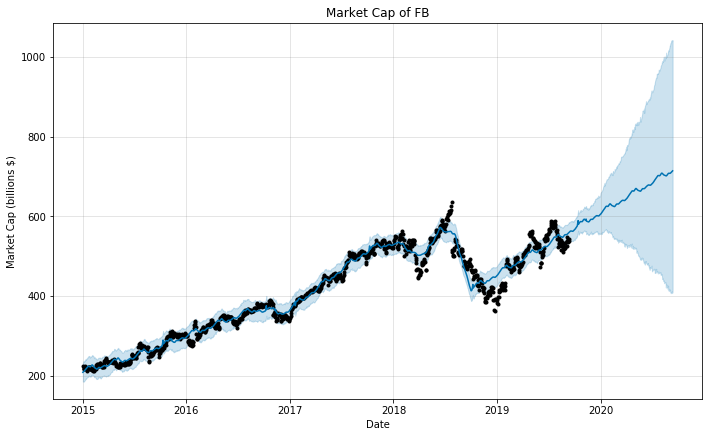

In [22]:
fb_cap_prophet.plot(fb_cap_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of FB');

#### Price

In [23]:
# Make the prophet model and fit on the data
fb_price_prophet = Prophet(weekly_seasonality=False,
                     yearly_seasonality=False,
                     daily_seasonality=False,
                     holidays=us_public_holidays, 
                     changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
fb_price_prophet.fit(fb_price)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [24]:
fb_price_validation = cross_validation(fb_price_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(fb_price_validation['y'], fb_price_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(fb_price_validation['y'], fb_price_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  17.375825168890692
RMSE:  35.8484727778081


In [25]:
# Make a future dataframe for 1 year
fb_price_forecast = fb_price_prophet.make_future_dataframe(periods=45, freq='B')
# Make predictions
fb_price_forecast = fb_price_prophet.predict(fb_price_forecast)

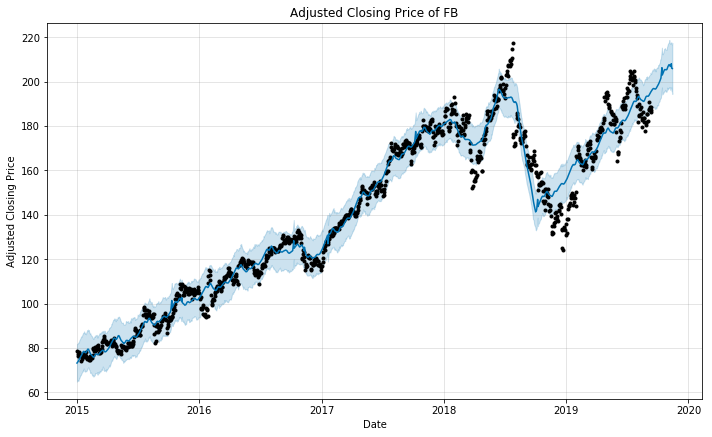

In [26]:
fb_price_prophet.plot(fb_price_forecast, xlabel = 'Date', ylabel = 'Adjusted Closing Price')
plt.title('Adjusted Closing Price of FB');

### Amazon Model

#### Market Cap

In [27]:
prime_day = pd.DataFrame({'holiday': 'Prime Day', 'ds' : pd.to_datetime(['2015-07-15','2016-07-12','2017-07-10', '2017-07-11','2017-07-12', '2018-07-16', '2018-07-17', '2019-07-15', '2019-07-16', '2019-07-17'])})
amzn_us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug, prime_day])

In [28]:
# Make the prophet model and fit on the data
amzn_cap_prophet = Prophet(weekly_seasonality=False,
                       yearly_seasonality=False,
                       daily_seasonality=False,
                       holidays=amzn_us_public_holidays,
                       changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
amzn_cap_prophet.fit(amzn_cap)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [29]:
amzn_cap_validation = cross_validation(amzn_cap_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(amzn_cap_validation['y'], amzn_cap_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(amzn_cap_validation['y'], amzn_cap_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  16.07256956881791
RMSE:  156.69019200694373


In [30]:
# Make a future dataframe for 1 year
amzn_cap_forecast = amzn_cap_prophet.make_future_dataframe(periods=261, freq='B')
# Make predictions
amzn_cap_forecast = amzn_cap_prophet.predict(amzn_cap_forecast)

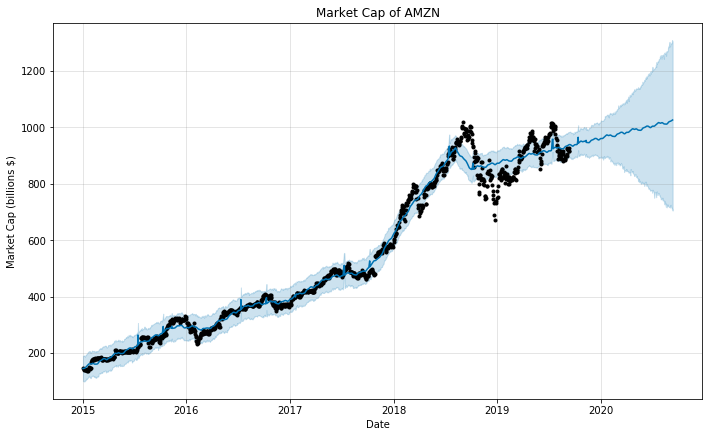

In [31]:
amzn_cap_prophet.plot(amzn_cap_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of AMZN');

#### Price

In [32]:
# Make the prophet model and fit on the data
amzn_price_prophet = Prophet(weekly_seasonality=False,
                       yearly_seasonality=False,
                       daily_seasonality=False,
                       holidays=amzn_us_public_holidays,
                       changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
amzn_price_prophet.fit(amzn_price)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [33]:
amzn_price_validation = cross_validation(amzn_price_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(amzn_price_validation['y'], amzn_price_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(amzn_price_validation['y'], amzn_price_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  15.546346446756157
RMSE:  305.3466660052409


In [34]:
# Make a future dataframe for 1 year
amzn_price_forecast = amzn_price_prophet.make_future_dataframe(periods=45, freq='B')
# Make predictions
amzn_price_forecast = amzn_price_prophet.predict(amzn_price_forecast)

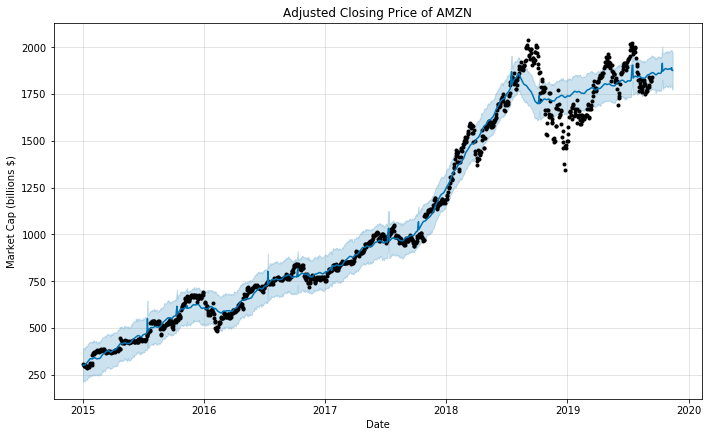

In [35]:
amzn_price_prophet.plot(amzn_price_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Adjusted Closing Price of AMZN');

### Microsoft Model

#### Market Cap

In [36]:
# Make the prophet model and fit on the data
msft_cap_prophet = Prophet(weekly_seasonality=False,
                       yearly_seasonality=False,
                       daily_seasonality=False,
                       holidays=us_public_holidays, 
                       changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
msft_cap_prophet.fit(msft_cap)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [37]:
msft_cap_validation = cross_validation(msft_cap_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(msft_cap_validation['y'], msft_cap_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(msft_cap_validation['y'], msft_cap_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  5.103714674572923
RMSE:  52.9410196404706


In [38]:
# Make a future dataframe for 1 year
msft_cap_forecast = msft_cap_prophet.make_future_dataframe(periods=261, freq='B')
# Make predictions
msft_cap_forecast = msft_cap_prophet.predict(msft_cap_forecast)

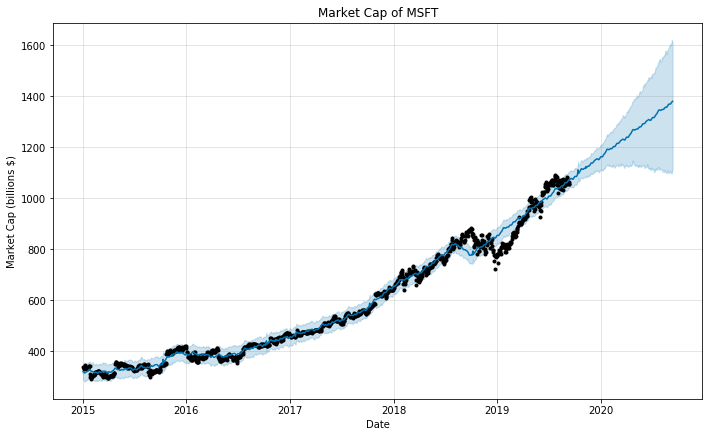

In [39]:
msft_cap_prophet.plot(msft_cap_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of MSFT');

#### Price

In [40]:
# Make the prophet model and fit on the data
msft_price_prophet = Prophet(weekly_seasonality=False,
                     yearly_seasonality=False,
                     daily_seasonality=False,
                     holidays=us_public_holidays, 
                     changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
msft_price_prophet.fit(msft_price[:-45])

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [41]:
msft_price_validation = cross_validation(msft_price_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(msft_price_validation['y'], msft_price_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(msft_price_validation['y'], msft_price_validation['yhat'])))

INFO:fbprophet:Making 4 forecasts with cutoffs between 2017-04-30 00:00:00 and 2018-10-22 00:00:00


MAPE:  6.681651401786852
RMSE:  8.174518959417972


In [42]:
# Make a future dataframe for 1 year
msft_price_forecast = msft_price_prophet.make_future_dataframe(periods=45, freq='B')
# Make predictions
msft_price_forecast = msft_price_prophet.predict(msft_price_forecast)

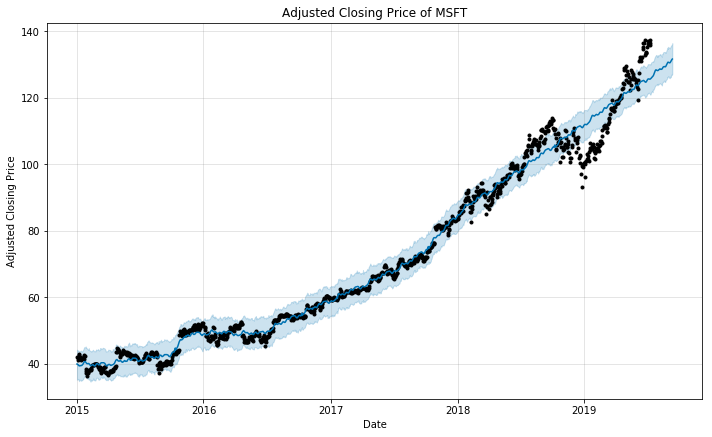

In [43]:
msft_price_prophet.plot(msft_price_forecast, xlabel = 'Date', ylabel = 'Adjusted Closing Price')
plt.title('Adjusted Closing Price of MSFT');

### Apple Model

#### Market Cap

In [44]:
# Make the prophet model and fit on the data
aapl_cap_prophet = Prophet(weekly_seasonality=False,
                       yearly_seasonality=False,
                       daily_seasonality=False,
                       holidays=us_public_holidays, 
                       changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
aapl_cap_prophet.fit(aapl_cap)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [45]:
aapl_cap_validation = cross_validation(aapl_cap_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(aapl_cap_validation['y'], aapl_cap_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(aapl_cap_validation['y'], aapl_cap_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  14.093867271621766
RMSE:  131.84453783107153


In [46]:
# Make a future dataframe for 1 year
aapl_cap_forecast = aapl_cap_prophet.make_future_dataframe(periods=261, freq='B')
# Make predictions
aapl_cap_forecast = aapl_cap_prophet.predict(aapl_cap_forecast)

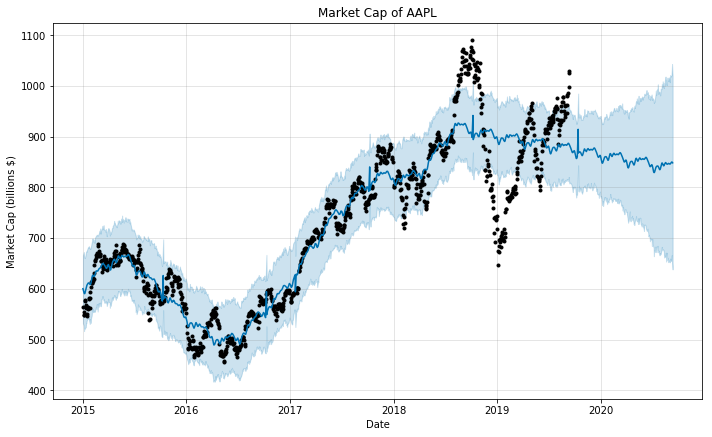

In [47]:
aapl_cap_prophet.plot(aapl_cap_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of AAPL');

#### Price

In [48]:
# Make the prophet model and fit on the data
aapl_price_prophet = Prophet(weekly_seasonality=False,
                     yearly_seasonality=False,
                     daily_seasonality=False,
                     holidays=us_public_holidays, 
                     changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
aapl_price_prophet.fit(aapl_price)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [49]:
aapl_price_validation = cross_validation(aapl_price_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(aapl_price_validation['y'], aapl_price_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(aapl_price_validation['y'], aapl_price_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  12.652930789185582
RMSE:  25.021636610113646


In [50]:
# Make a future dataframe for 1 year
aapl_price_forecast = aapl_price_prophet.make_future_dataframe(periods=45, freq='B')
# Make predictions
aapl_price_forecast = aapl_price_prophet.predict(aapl_price_forecast)

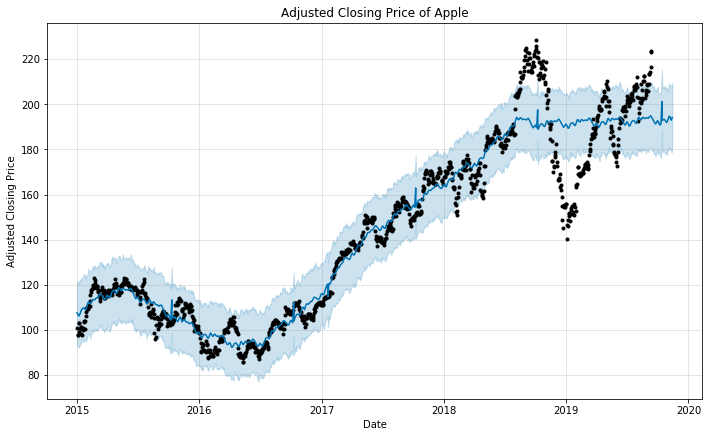

In [51]:
aapl_price_prophet.plot(aapl_price_forecast, xlabel = 'Date', ylabel = 'Adjusted Closing Price')
plt.title('Adjusted Closing Price of Apple');

### Google Model

#### Market Cap

In [52]:
# Make the prophet model and fit on the data
googl_cap_prophet = Prophet(weekly_seasonality=False,
                        yearly_seasonality=False,
                        daily_seasonality=False,
                        holidays=us_public_holidays,
                        changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
googl_cap_prophet.fit(googl_cap)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [53]:
googl_cap_validation = cross_validation(googl_cap_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(googl_cap_validation['y'], googl_cap_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(googl_cap_validation['y'], googl_cap_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  7.105686407933799
RMSE:  65.65247406724411


In [54]:
# Make a future dataframe for 1 year
googl_cap_forecast = googl_cap_prophet.make_future_dataframe(periods=261, freq='B')
# Make predictions
googl_cap_forecast = googl_cap_prophet.predict(googl_cap_forecast)

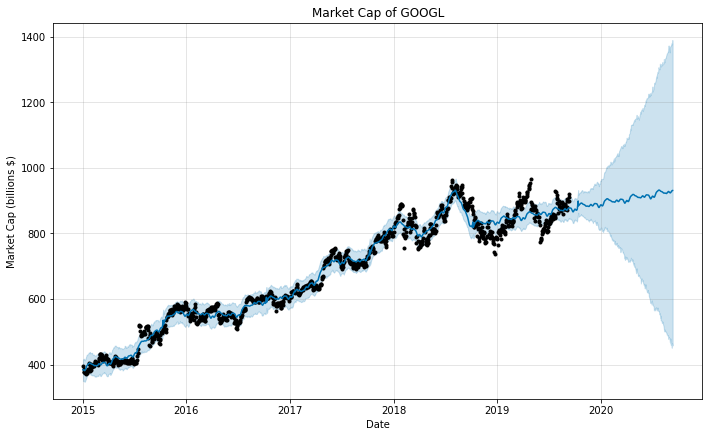

In [55]:
googl_cap_prophet.plot(googl_cap_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GOOGL');

#### Price

In [56]:
# Make the prophet model and fit on the data
googl_price_prophet = Prophet(weekly_seasonality=False,
                     yearly_seasonality=False,
                     daily_seasonality=False,
                     holidays=us_public_holidays, 
                     changepoint_prior_scale=0.15)\
                .add_seasonality('quarterly_seasonality',period=91.25,fourier_order=8,mode='additive')
googl_price_prophet.fit(googl_price)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [57]:
googl_price_validation = cross_validation(googl_price_prophet, initial='730 days', period='180 days', horizon = '261 days')
print('MAPE: ', mean_absolute_percentage_error(googl_price_validation['y'], googl_price_validation['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(googl_price_validation['y'], googl_price_validation['yhat'])))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2017-01-04 00:00:00 and 2018-12-25 00:00:00


MAPE:  7.03101188898772
RMSE:  86.90917677923566


In [58]:
# Make a future dataframe for 1 year
googl_price_forecast = googl_price_prophet.make_future_dataframe(periods=45, freq='B')
# Make predictions
googl_price_forecast = googl_price_prophet.predict(googl_price_forecast)

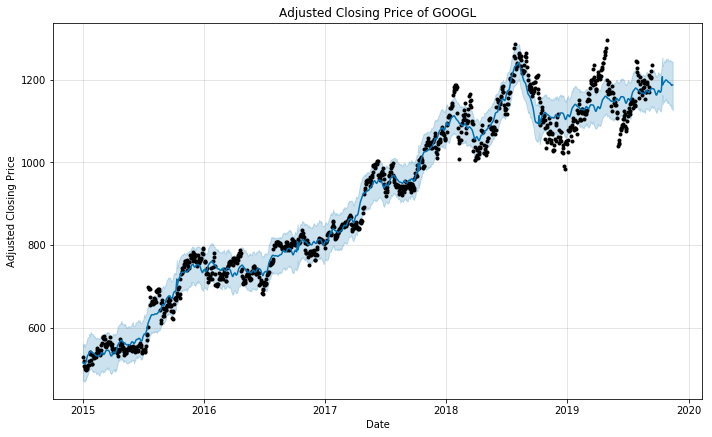

In [59]:
googl_price_prophet.plot(googl_price_forecast, xlabel = 'Date', ylabel = 'Adjusted Closing Price')
plt.title('Adjusted Closing Price of GOOGL');

## Plot Forecasts

Text(0.5, 1.0, 'Market Capitalization Trend Predictions')

<Figure size 1680x1200 with 0 Axes>

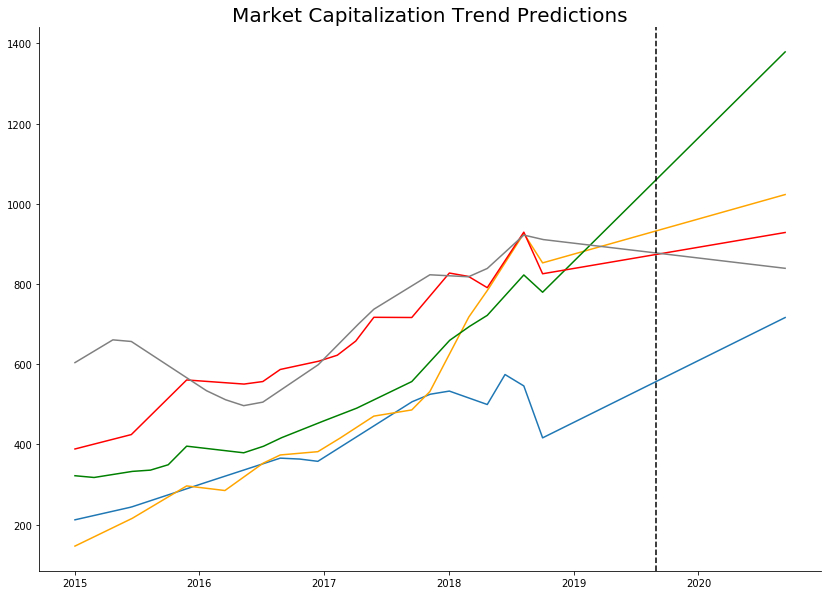

In [67]:
plt.figure(figsize=(14, 10), dpi=120)
fig, ax = plt.subplots(figsize=(14, 10))

ax.plot(fb_cap_forecast['ds'], fb_cap_forecast['trend'], label='FB')
ax.plot(amzn_cap_forecast['ds'], amzn_cap_forecast['trend'], label='AMZN', color="orange")
ax.plot(msft_cap_forecast['ds'], msft_cap_forecast['trend'], label='MSFT', color="green")
ax.plot(googl_cap_forecast['ds'], googl_cap_forecast['trend'], label='GOOGL', color="red")
ax.plot(aapl_cap_forecast['ds'], aapl_cap_forecast['trend'], label='AAPL', color="gray")
ax.axvline(pd.to_datetime('2019-8-30'), color='k', linestyle='--')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#plt.xlabel('Year', fontsize=14)
#plt.ylabel('Market Capitalization (Billions $)', fontsize=14)
plt.title('Market Capitalization Trend Predictions', fontsize=20)

Text(0.5, 1.0, 'Big 5 Trend Predictions')

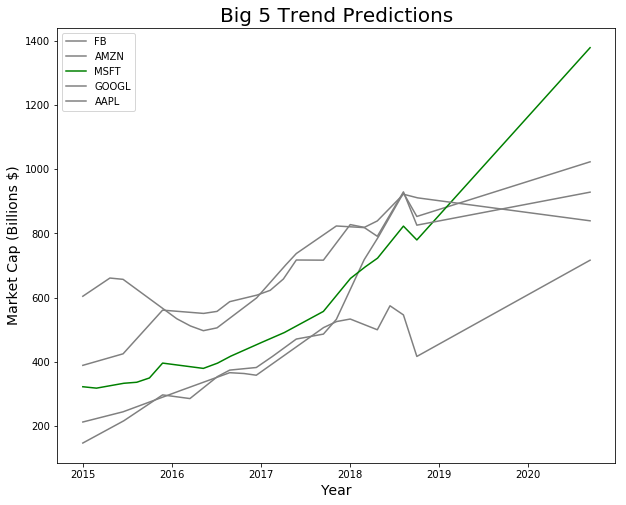

In [61]:
plt.figure(figsize=(10, 8))
plt.plot(fb_cap_forecast['ds'], fb_cap_forecast['trend'], label='FB', color="gray")
plt.plot(amzn_cap_forecast['ds'], amzn_cap_forecast['trend'], label='AMZN', color="gray")
plt.plot(msft_cap_forecast['ds'], msft_cap_forecast['trend'], label='MSFT', color="green")
plt.plot(googl_cap_forecast['ds'], googl_cap_forecast['trend'], label='GOOGL', color="gray")
plt.plot(aapl_cap_forecast['ds'], aapl_cap_forecast['trend'], label='AAPL', color="gray")
plt.legend()
plt.xlabel('Year', fontsize=14)
plt.ylabel('Market Cap (Billions $)', fontsize=14)
plt.title('Big 5 Trend Predictions', fontsize=20)

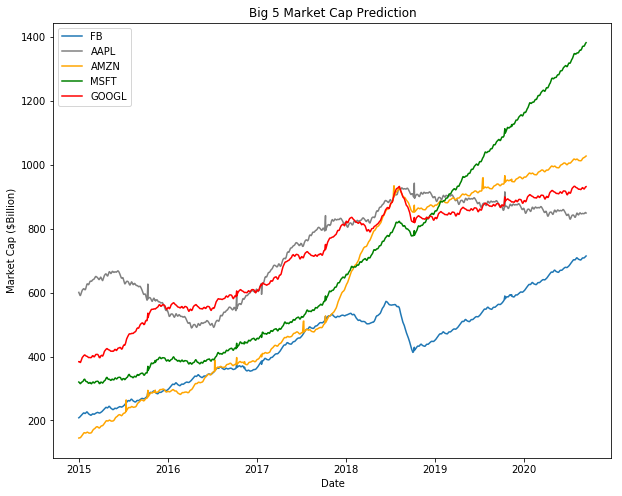

In [62]:
plt.figure(figsize=(10, 8))
plt.plot(fb_cap_forecast['ds'], fb_cap_forecast['yhat'], label='FB')
plt.plot(aapl_cap_forecast['ds'], aapl_cap_forecast['yhat'], label='AAPL', color="gray")
plt.plot(amzn_cap_forecast['ds'], amzn_cap_forecast['yhat'], label='AMZN', color="orange")
plt.plot(msft_cap_forecast['ds'], msft_cap_forecast['yhat'], label='MSFT', color="green")
plt.plot(googl_cap_forecast['ds'], googl_cap_forecast['yhat'], label='GOOGL', color="red")
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($Billion)')
plt.title('Big 5 Market Cap Prediction');

In [63]:
msft_price['ds'][-45:].head(1)

1137    2019-07-11
Name: ds, dtype: object

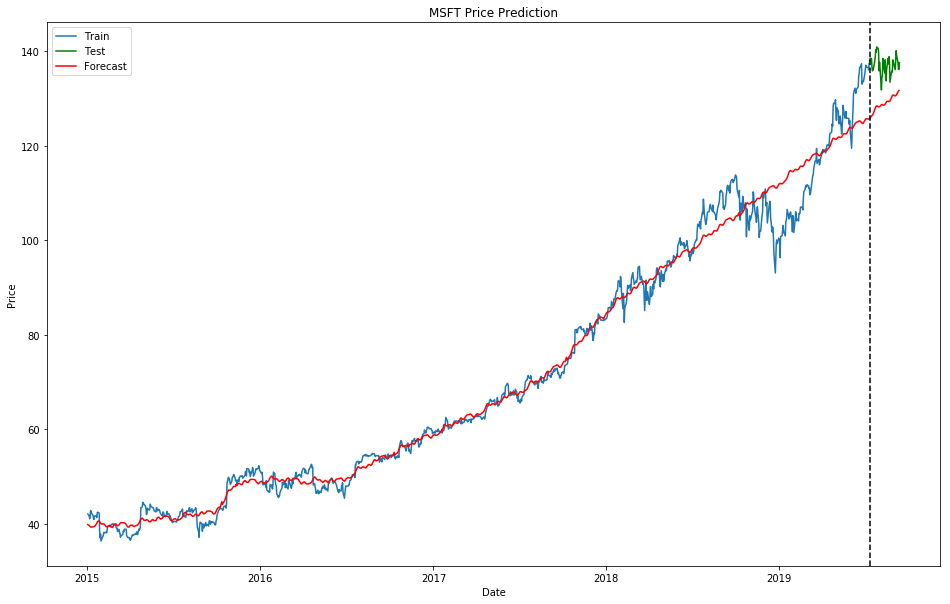

In [64]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(msft_price[:-45]['ds'], msft_price[:-45]['y'], label='Train')
ax.plot(msft_price[-45:]['ds'], msft_price[-45:]['y'], label='Test', color='green')
ax.plot(msft_price_forecast['ds'], msft_price_forecast['yhat'], label='Forecast', color="red")
ax.axvline(pd.to_datetime(np.array(msft_price['ds'])[-45]), color='k', linestyle='--')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Price')
plt.title('MSFT Price Prediction');

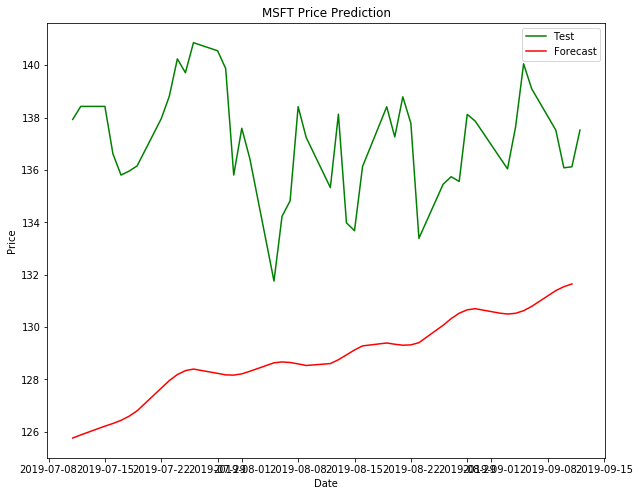

In [65]:
plt.figure(figsize=(10, 8))
plt.plot(msft_price[-45:]['ds'], msft_price[-45:]['y'], label='Test', color='green')
plt.plot(msft_price_forecast[-45:]['ds'], msft_price_forecast[-45:]['yhat'], label='Forecast', color="red")
plt.legend(); plt.xlabel('Date'); plt.ylabel('Price')
plt.title('MSFT Price Prediction');